# Aula 13 - Multi-Armed Bandits - MovieLens

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans


In [ ]:
# Carregamento do dataset MovieLens
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Filtragem e criação de coluna de feedback positivo (rating >= 3)
ratings['positive_feedback'] = ratings['rating'] >= 3

# Divisão em conjunto de treino e teste (80% treino, 20% teste)
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Mapeamento dos IDs de filmes e usuários para índices contínuos
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(ratings['movie_id'].unique())}
user_id_map = {user_id: idx for idx, user_id in enumerate(ratings['user_id'].unique())}

# Substituir os IDs de filme e usuário pelos índices mapeados
train_ratings['movie_idx'] = train_ratings['movie_id'].map(movie_id_map)
train_ratings['user_idx'] = train_ratings['user_id'].map(user_id_map)
test_ratings['movie_idx'] = test_ratings['movie_id'].map(movie_id_map)
test_ratings['user_idx'] = test_ratings['user_id'].map(user_id_map)

# Carregar a tabela de filmes do MovieLens, que contém os gêneros dos filmes
movies_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
               'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 
               'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
               'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Selecionamos apenas as colunas de gênero (binárias) do dataframe
movie_genres = movies.set_index('movie_id')[movies_cols[5:]].copy()  # As colunas de gêneros começam na posição 5

# Atualizar movie_genres para usar os índices contínuos (movie_idx)
movie_genres.index = movie_genres.index.map(movie_id_map)

# Agora vamos carregar as informações dos usuários
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')

# Criar faixas etárias para os usuários
def categorize_age(age):
    if age <= 18:
        return '0-18'
    elif 19 <= age <= 30:
        return '19-30'
    elif 31 <= age <= 50:
        return '31-50'
    else:
        return '51+'

# Aplicar a categorização de idade
users['age_group'] = users['age'].apply(categorize_age)

# Converter a faixa etária para variáveis binárias (dummies)
age_dummies = pd.get_dummies(users['age_group'])

# Atualizar user_features para usar os índices contínuos e incluir apenas a faixa etária
user_features = age_dummies.set_index(users['user_id'].map(user_id_map))

# Função para criar o vetor de contexto combinando características de usuário e filme usando índices
def get_context(user_idx, movie_idx):
    user_context = user_features.loc[user_idx].values  # Vetor de características do usuário    
    movie_context = movie_genres.loc[movie_idx].values  # Vetor de características do filme (gêneros)
    return np.concatenate([user_context, movie_context])  # Combina as características de usuário e filme


In [3]:
# Algoritmo UCB1 com ajuste para explorar filmes populares inicialmente
class UCB1Recommender:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Número de vezes que cada filme foi recomendado
        self.values = np.zeros(n_arms)  # Valor esperado de recompensa para cada filme
    
    def select_arm(self):
        # Algoritmo UCB1
        total_counts = np.sum(self.counts)
        if total_counts == 0:
            return np.random.randint(0, self.n_arms)  # Se nenhum filme foi selecionado ainda, escolha aleatoriamente
        
        ucb_values = self.values + np.sqrt(2 * np.log(total_counts) / (self.counts + 1e-5))  # Evitar divisão por zero
        return np.argmax(ucb_values)
    
    def update(self, chosen_arm, reward):
        # Atualiza as estimativas do braço selecionado com base na recompensa observada
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [4]:
# Algoritmo Epsilon-Greedy
class EpsilonGreedyRecommender:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon  # Probabilidade de exploração
        self.counts = np.zeros(n_arms)  # Número de vezes que cada filme foi recomendado
        self.values = np.zeros(n_arms)  # Valor esperado de recompensa para cada filme
    
    def select_arm(self):
        # Com probabilidade epsilon, fazemos uma escolha aleatória (exploração)
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        # Caso contrário, fazemos explotação
        return np.argmax(self.values)
    
    def update(self, chosen_arm, reward):
        # Atualiza as estimativas do braço selecionado com base na recompensa observada
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value
        

In [5]:
# Algoritmo Thompson Sampling
class ThompsonSamplingRecommender:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.successes = np.zeros(n_arms)  # Número de sucessos (recompensa 1)
        self.failures = np.zeros(n_arms)  # Número de falhas (recompensa 0)
    
    def select_arm(self):
        # Amostra da distribuição Beta para cada braço e escolhe o que tem a maior amostra
        beta_samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.n_arms)]
        return np.argmax(beta_samples)
    
    def update(self, chosen_arm, reward):
        # Atualiza os parâmetros da distribuição Beta com base na recompensa
        if reward == 1:
            self.successes[chosen_arm] += 1
        else:
            self.failures[chosen_arm] += 1
            

In [6]:
# Algoritmo LinUCB personalizado para cada usuário usando gêneros como contexto
class LinUCBRecommender:
    def __init__(self, n_features, n_arms, alpha=1.5): 
        self.alpha = alpha  # Parâmetro de confiança
        self.n_arms = n_arms
        
        # Para cada arm, teremos uma matriz A e um vetor b
        self.A = [np.identity(n_features) for _ in range(n_arms)]  # Matriz A para cada arm
        self.b = [np.zeros(n_features) for _ in range(n_arms)]  # Vetor b para cada arm
    
    def select_arm(self, contexts):
        # Calcular p(a) para cada contexto
        p = np.zeros(self.n_arms)
        
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])  # Inversa de A para cada arm
            theta = np.dot(A_inv, self.b[arm])  # Estimativa de theta para cada arm
            context = contexts[arm]
            
            # p(a) = theta^T * x + alpha * sqrt(x^T * A^-1 * x)
            p[arm] = np.dot(theta, context) + self.alpha * np.sqrt(np.dot(context.T, np.dot(A_inv, context)))
        
        return np.argmax(p)  # Seleciona o braço com a maior estimativa de recompensa
    
    
    def update(self, chosen_arm, contexts, reward):
        # Atualizar as estimativas A e b com base no braço escolhido
        chosen_context = contexts[chosen_arm]  # Obter o contexto do braço escolhido
        
        # Atualização da matriz A e vetor b para o braço escolhido
        self.A[chosen_arm] += np.outer(chosen_context, chosen_context)  # Atualiza A para o braço escolhido
        self.b[chosen_arm] += reward * chosen_context  # Atualiza b para o braço escolhido
        

In [7]:
# Função para simular o processo de recomendação para todos os usuários usando os dados de treino
def train_recommender(recommender, train_ratings):
    # Agrupar os ratings pelo ID do usuário para evitar filtragens repetidas
    for user_idx, user_ratings in tqdm(train_ratings.groupby('user_idx'), desc="Training", unit="user"):

        movie_indices = user_ratings['movie_idx'].values
        positive_feedback = user_ratings['positive_feedback'].values

        for i, movie_idx in enumerate(movie_indices):
            reward = 1 if positive_feedback[i] else 0  # Pega diretamente o feedback
            if isinstance(recommender, LinUCBRecommender):
                context = get_context(user_idx, movie_idx)  # Obter o contexto combinado usando índices
                recommender.update(0, [context], reward)
            else:
                recommender.update(movie_idx, reward)

# Função para testar o recomendador e calcular o ganho acumulado
def test_recommender(recommender, test_ratings, n_rounds_per_user, available_movies):
    cumulative_rewards = np.zeros(n_rounds_per_user)
    num_users = test_ratings['user_idx'].nunique()  # Número de usuários únicos
    
    # Verificar o tipo do recomendador uma única vez antes do loop
    is_linucb = isinstance(recommender, LinUCBRecommender)
        
    # Agrupar os ratings por usuário para evitar filtragem repetida
    for user_idx, user_ratings in tqdm(test_ratings.groupby('user_idx'), desc="Testing", unit="user"):
        # Preencher os ratings do usuário em arrays para evitar filtragens repetidas
        user_movie_indices = user_ratings['movie_idx'].values
        user_ratings_values = user_ratings['rating'].values
        
        # Se o recomendador for do tipo LinUCB, calcular os contextos específicos para o usuário atual
        if is_linucb:
            # Criar contextos dos filmes apenas para este usuário
            user_context = {movie_idx: get_context(user_idx, movie_idx) for movie_idx in available_movies}
        
        for round_idx in range(n_rounds_per_user):            
            # Seleciona o filme com a maior estimativa de recompensa
            if is_linucb:
                chosen_arm = recommender.select_arm(user_context)
            else:
                chosen_arm = recommender.select_arm()

            # Verificar se o filme escolhido foi assistido pelo usuário e obter o rating
            if chosen_arm in user_movie_indices:
                movie_idx = np.where(user_movie_indices == chosen_arm)[0][0]
                movie_rating = user_ratings_values[movie_idx]
            else:
                movie_rating = 0  # Se o filme não foi assistido, consideramos a recompensa como 0
            
            reward = 1 if movie_rating >= 3 else 0
            
            # Atualizar o modelo com o braço escolhido e a recompensa
            if is_linucb:
                recommender.update(chosen_arm, user_context, reward)
            else:
                recommender.update(chosen_arm, reward)
            
            # Acumular as recompensas para essa rodada
            cumulative_rewards[round_idx] += reward
    
    # Agora calculamos a média do ganho acumulado por usuário
    cumulative_rewards /= num_users
    
    return cumulative_rewards


**Exercício 01:** No exemplo do notebook anterior, executamos o LinUCB com uma representação de contexto composta pela faixa etária do usuário, concatenada com a lista de gêneros dos filmes. Entretanto, a faixa etária não é uma boa estratégia para diferenciar um usuário: pode ser que usuários em uma mesma faixa etária possuam preferências diferentes, ou que usuários de faixas etárias diferentes possuam gostos parecidos. O exercício dessa semana consiste em aplicar uma técnica de clusterização nos usuários, e usar essa informação de cluster para definir o contexto a ser passado para o LinUCB. 

Você poderá usar um algoritmo simples de clusterização (como o K-Means), definindo um número de clusters inicial. A representação de cada usuário pode ser feita pelas notas que ele atribuiu aos itens no conjunto de treinamento. Após cluterizar, crie uma representação one-hot encoding para cada grupo de usuários, a qual poderá ser concatenada com outras informações dos filmes. Verifique o desempenho do LinUCB de acordo com o ganho acumulado médio.  

### Preparar os dados para Clusterização

In [14]:
# Criar a matriz Usuario Item para Clusterizar com os dados de treino
user_ids = train_ratings['user_idx']
movie_ids = train_ratings['movie_idx']
ratings_values = train_ratings['rating']

# Dimensões da matriz
num_users = len(user_id_map)
num_items = len(movie_id_map)

# Criar uma matriz esparsa no formato CSR
user_item_matrix = csr_matrix((ratings_values, (user_ids, movie_ids)), shape=(num_users, num_items))

### Aplicar a Clusterização com o K-Means

In [ ]:
n_clusters = 20

# usar o K-Means para dividir em n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)

kmeans.fit(user_item_matrix)

# Obter a atribuição de Cluster para cada usuario
user_cluster_labels = kmeans.labels_

# Guardar para uso futuro
user_clusters = pd.Series(user_cluster_labels, index=range(user_item_matrix.shape[0]))

print(user_clusters.head(10))

0    18
1     8
2     4
3    13
4    12
5    13
6     4
7    13
8     7
9     7
dtype: int32


### Converter Clusters para One Hot Encoding

In [20]:
# Usand o get_dummies do pandas para isso
cluster_one_hot = pd.get_dummies(user_clusters, prefix='cluster')

display(cluster_one_hot.head())

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


### Adaptar get_context para usar os Clusters ao invés da faixa etária

In [ ]:
def get_context_with_clusters(user_idx, movie_idx):
    user_context = cluster_one_hot.loc[user_idx].values
    movie_context = movie_genres.loc[movie_idx].values
    
    # Combinar os dois vetores
    return np.concatenate([user_context, movie_context])

# Testar a nova função para um usuário e um filme aleatórios
sample_context = get_context_with_clusters(1, 15)

print(sample_context)
print(len(sample_context))

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0]
39


### Treinar e testar com o Cluster

Testing: 100%|██████████| 940/940 [1:56:25<00:00,  7.43s/user]  



--- Resultado Final ---


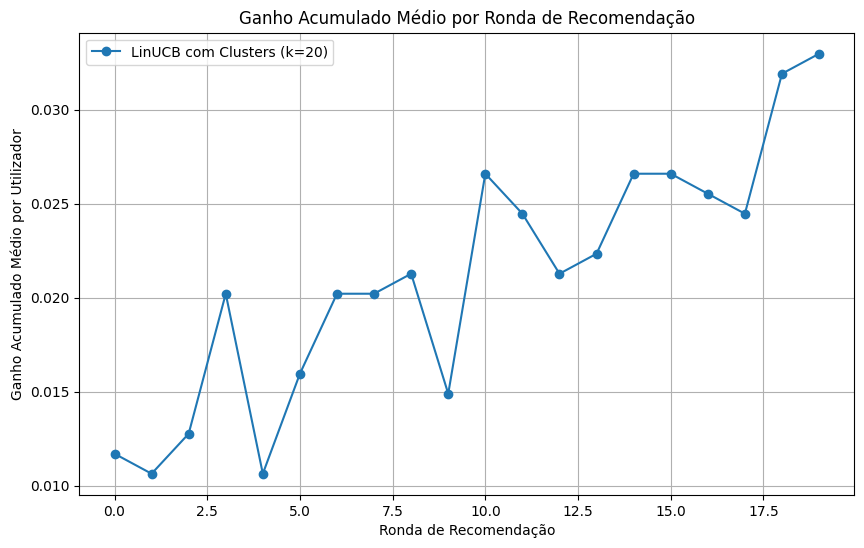


Ganho acumulado médio final após 20 rondas usando clusters: 0.0330


In [ ]:

def train_recommender_with_clusters(recommender, train_ratings):
    # Agrupar por utilizador para eficiência
    for user_idx, user_ratings in tqdm(train_ratings.groupby('user_idx'), desc="Training", unit="user"):
        movie_indices = user_ratings['movie_idx'].values
        positive_feedback = user_ratings['positive_feedback'].values

        for i, movie_idx in enumerate(movie_indices):
            reward = 1 if positive_feedback[i] else 0
            context = get_context_with_clusters(user_idx, movie_idx)
            contexts_list = [np.zeros_like(context)] * recommender.n_arms 
            contexts_list[movie_idx] = context 
            
            recommender.update(movie_idx, contexts_list, reward)


def test_recommender_with_clusters(recommender, test_ratings, n_rounds_per_user):
    cumulative_rewards = np.zeros(n_rounds_per_user)
    num_users = test_ratings['user_idx'].nunique()
    available_movies = movie_genres.index.unique().tolist()

    for user_idx, user_ratings in tqdm(test_ratings.groupby('user_idx'), desc="Testing", unit="user"):
        user_movie_indices = user_ratings['movie_idx'].values
        user_ratings_values = user_ratings['rating'].values
        
        user_all_contexts = {movie_idx: get_context_with_clusters(user_idx, movie_idx)
                             for movie_idx in available_movies}
        
        for round_idx in range(n_rounds_per_user):
            chosen_arm = recommender.select_arm(user_all_contexts)

            if chosen_arm in user_movie_indices:
                movie_idx_in_user_data = np.where(user_movie_indices == chosen_arm)[0][0]
                movie_rating = user_ratings_values[movie_idx_in_user_data]
                reward = 1 if movie_rating >= 3 else 0
            else:
                reward = 0
            
            recommender.update(chosen_arm, user_all_contexts, reward)
            
            cumulative_rewards[round_idx] += reward
            
    cumulative_rewards /= num_users
    return cumulative_rewards


n_arms_total = len(movie_id_map)
linucb_cluster_model = LinUCBRecommender(n_features=len(sample_context), n_arms=n_arms_total, alpha=1.5)

train_recommender_with_clusters(linucb_cluster_model, train_ratings)

n_rounds = 20 # Número de recomendações a simular por utilizador
cluster_rewards = test_recommender_with_clusters(linucb_cluster_model, test_ratings, n_rounds)

plt.figure(figsize=(10, 6))
plt.plot(cluster_rewards, label=f'LinUCB com Clusters (k={n_clusters})', marker='o')

plt.title('Ganho Acumulado Médio por Ronda de Recomendação')
plt.xlabel('Ronda de Recomendação')
plt.ylabel('Ganho Acumulado Médio por Utilizador')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nGanho acumulado médio final após {n_rounds} rondas usando clusters: {cluster_rewards[-1]:.4f}")

Nota: eu até rodaria mais para conseguir mais dados, só que demoraram 2 horas pra esse código rodar, porfavor tenha piedade 